# <span style="color:green"> LSTM RNN 

# Importing Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import tensorflow as tf
from sklearn import datasets
from sklearn.model_selection import train_test_split
# import pylab as pl
import matplotlib.pyplot as plt
from IPython import display
import sys
%matplotlib inline

# LSTM class and functions

$$
\begin{align}
Input\;activation: &z^t=g(W_zx^t+R_zy^{t-1}+b_z)=g(z_a^t) \\
Input\;gate: &i^t=\sigma(W_ix^t+R_iy^{t-1}+b_i)=\sigma(i_a^t) \\
Forget\;gate: &f^t=\sigma(W_fx^t+R_fy^{t-1}+b_f)=\sigma(f_a^t) \\
Memory\;Cell: &c^t=i^tz^t+f^tc^{t-1} \\
Output\;gate: &o^t=\sigma(W_ox^t+R_oy^{t-1}+b_o)=\sigma(o_a^t) \\
Hidden\;state: &y^t=o^th(c^t)=o^tc_h^t
\end{align}
$$

In [2]:
class LSTM_cell(object):


    def __init__(self, input_size, hidden_layer_size, target_size):

        # Initialization of given values
        self.input_size = input_size
        self.hidden_layer_size = hidden_layer_size
        self.target_size = target_size
                
        # input gate的參數, x_t * W + y_{t-1} * U + b_t
        # Weights and Bias for input and hidden tensor
        self.Wi = tf.Variable(tf.truncated_normal( # t時間點的參數
            [self.input_size, self.hidden_layer_size],stddev=.01))
        self.Ui = tf.Variable(tf.truncated_normal( # t-1時間點的參數
            [self.hidden_layer_size, self.hidden_layer_size],stddev=.01))
        self.bi = tf.Variable(tf.zeros([self.hidden_layer_size])) # t時間點參數

        # forget gate的參數
        self.Wf = tf.Variable(tf.truncated_normal(
            [self.input_size, self.hidden_layer_size],stddev=.01))
        self.Uf = tf.Variable(tf.truncated_normal(
            [self.hidden_layer_size, self.hidden_layer_size],stddev=.01))
        self.bf = tf.Variable(tf.zeros([self.hidden_layer_size]))        
        
        # output gate的參數
        self.Wog = tf.Variable(tf.truncated_normal(
            [self.input_size, self.hidden_layer_size],stddev=.01))
        self.Uog = tf.Variable(tf.truncated_normal(
            [self.hidden_layer_size, self.hidden_layer_size],stddev=.01))
        self.bog = tf.Variable(tf.zeros([self.hidden_layer_size]))        
        
        # input activation的參數
        self.Wz = tf.Variable(tf.truncated_normal(
            [self.input_size, self.hidden_layer_size],stddev=.01))
        self.Uz = tf.Variable(tf.truncated_normal(
            [self.hidden_layer_size, self.hidden_layer_size],stddev=.01))
        self.bz = tf.Variable(tf.zeros([self.hidden_layer_size]))        
        
        
        
        # Weights for output layers
        self.Wo = tf.Variable(tf.truncated_normal( # 自訂均值及標準差, truncated表示如果正態分布的值若與均值的差超過兩倍標準差，就重新生成
            [self.hidden_layer_size, self.target_size],mean=0,stddev=.01))
        self.bo = tf.Variable(tf.truncated_normal([self.target_size],mean=0,stddev=.01))

        # Placeholder for input vector with shape(batch,timesteps,features)
        self._inputs = tf.placeholder(tf.float32,
                                      shape=[None, None, self.input_size],
                                      name='inputs')

        # Processing inputs to work with scan function(timesteps,batch,features)
        self.processed_input = process_batch_input_for_RNN(self._inputs)
        # 使用transpose將input從[batch,timesteps,features]轉成[timesteps,batch,features]，是為了後面tf.scan使用
        # 每次計算[1,batch,feature]，也就是所有batch資料的第一個timestep

        #==================================================================
        # 在第一個timestep的hidden_state以及cell裏的值，兩者shape皆為[batch,hidden_layer_size]
        # 如果沒有特別指定，就全部設為0
        self.initial_hidden = self._inputs[:, 0, :] # 挑出第一個timestep , shape為[batch,input_size], 中間的timestep維度會不見
        self.initial_hidden= tf.matmul(
            self.initial_hidden, tf.zeros([input_size, hidden_layer_size])) 
        # [batch,input_size]*[input_size,hidden_layer_size] = [batch, hidden_layer_size]
        # 可以直接寫self.initial_hidden = tf.zero([None, hidden_layer_size])
        
        self.initial_cell = self.initial_hidden # 兩者shape一樣，在initial階段也全部都是零
        
        # tf.stack([a,b],axis=0)，矩陣拼接，合併a與b，axis=0表示多新增一個維度
        # tf.stack的目的是拼接兩個tensor，shape為[2,batch,hidden_layer_size]，是為了給tf.scan使用
        self.initial_hidden_cell=tf.stack([self.initial_hidden,self.initial_cell])
        
    # Function for LSTM cell.，定義一個function，用於每一個timestep的計算
    def Lstm(self, previous_hidden_memory_tuple, x):

        # 每次都會拿上一個timestep的hidden_state與cell的值
        previous_hidden_state,c_prev=tf.unstack(previous_hidden_memory_tuple) # 按照第一維度分解
        
        #Input Gate
        i= tf.sigmoid(
            tf.matmul(x,self.Wi)+tf.matmul(previous_hidden_state,self.Ui) + self.bi
        )
        
        #Forget Gate
        f= tf.sigmoid(
            tf.matmul(x,self.Wf)+tf.matmul(previous_hidden_state,self.Uf) + self.bf 
        )
        
        #Output Gate
        o= tf.sigmoid(
            tf.matmul(x,self.Wog)+tf.matmul(previous_hidden_state,self.Uog) + self.bog
        )
        
        #Input activation
        z= tf.nn.tanh(
            tf.matmul(x,self.Wz)+tf.matmul(previous_hidden_state,self.Uz) + self.bz
        )
        
        #Final Memory cell
        c= f*c_prev + i*z
        
        #Current Hidden state
        current_hidden_state = o*tf.nn.tanh(c)


        return tf.stack([current_hidden_state,c]) # 按照第一維度拼接，準備接給下一個timestep的Lstm

    # Function for getting all hidden state.
    # 使用scan逐次迭代計算所有timesteps，最後得出所有的hidden_state進行後續處理
    def get_states(self):

        # Getting all hidden state through time
        # tf.scan 遞歸函數
        # fn: 第一個輸入是上一個時刻的輸出(需要與fn的輸出保持一致)，第二個輸入是當前時刻的輸入，以此類推
        # elems: scan方法每一步都會沿著tensor的第一個維度進行fn運算取值，也就是每筆資料的第一步timestep
        # 所以前面才要將self._input的shape由[batch,timesteps,features]轉成self.processed_input的shape[timesteps,batch,features]
        # initializer: 初始值，需與fn的第一個輸入和輸出保持一致
        # 最後得到的值維度為[timesteps, 2, batch, hidden_layer_size]，第二個維度是由hidden_state與cell組成
        # 而lstm cell的輸出就是第一個維度，hidden_state的值
        all_hidden_states = tf.scan(fn=self.Lstm, 
                                    elems=self.processed_input, # shape[timesteps, batch, features]
                                    initializer=self.initial_hidden_cell, # shape(2,batch,hidden_layer_size)
                                    name='states')
        all_hidden_states=all_hidden_states[:,0,:,:]
        
        return all_hidden_states

    # Function to get output from a hidden layer
    def get_output(self, hidden_state): 

        output = tf.matmul(hidden_state, self.Wo) + self.bo

        return output

    # Function for getting all output layers
    def get_outputs(self):

        all_hidden_states = self.get_states() # 拿到所有hidden_state的值，shape為[timesteps,batch,hidden_layer_size]
        
        # tf.map_fn依序拿取elems的第一個維度，接著計算fn的值，也就是每步timesteps都會輸出10類的概率
        # [batch,hidden_layer_size] * [hidden_layer_size, target_size] = [batch, target_size]
        # 最後得到[timesteps, batch, target_size]
        all_outputs = tf.map_fn(fn=self.get_output, 
                                elems=all_hidden_states) 

        return all_outputs


# Function to convert batch input data to use tf.scan ops of tensorflow.
def process_batch_input_for_RNN(batch_input):

    batch_input_ = tf.transpose(batch_input, perm=[1, 0, 2])
    X = tf.transpose(batch_input_)

    return X


# Placeholder and initializers


In [3]:
hidden_layer_size = 30
input_size = 8
target_size = 10

In [4]:
y = tf.placeholder(tf.float32, shape=[None, target_size],name='inputs')

# Models

In [5]:
#Initializing rnn object
rnn=LSTM_cell( input_size, hidden_layer_size, target_size)

In [6]:
all_hidden_states = rnn.get_states() # 所有hidden_state的值

In [7]:
#Getting all outputs from rnn
outputs = rnn.get_outputs() # 只需要最後一個timestep中10類的值

In [8]:
#Getting final output through indexing after reversing
last_output = outputs[-1]

In [9]:
#Computing the Cross Entropy loss 
loss = tf.reduce_sum(tf.nn.softmax_cross_entropy_with_logits_v2(logits=last_output, labels=y))

In [12]:
# Trainning with Adadelta Optimizer
train_step = tf.train.AdamOptimizer().minimize(loss)

In [13]:
#Calculatio of correct prediction and accuracy
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(last_output,1))
accuracy = (tf.reduce_mean(tf.cast(correct_prediction, tf.float32)))*100

# Dataset Preparation

In [14]:
#Function to get on hot
def get_on_hot(number):
    on_hot=[0]*10 # digits共有10類
    on_hot[number]=1
    return on_hot

In [15]:
#Using Sklearn MNIST dataset.
digits = datasets.load_digits()
X=digits.images
Y_=digits.target

Y=list(map(get_on_hot,Y_))

In [16]:
#Getting Train and test Dataset
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.22, random_state=42)

# #Cuttting for simple iteration
X_train=X_train[:1400]
y_train=y_train[:1400]

In [17]:
sess=tf.Session()
sess.run(tf.global_variables_initializer())

In [18]:
#Iterations to do trainning
train_loss = []
test_loss = []
train_acc = []
test_acc = []

for epoch in range(120):
    
    start=0
    end=100
    
    train_loss_collector = []
    test_loss_collector = []
    train_acc_collector = []
    test_acc_collector = []
    
    for i in range(14):
        
        X=X_train[start:end]
        Y=y_train[start:end]
        start=end
        end=start+100 # 每次訓練100張圖片
        _, train_loss_batch, train_acc_batch = sess.run([train_step, loss, accuracy],feed_dict={rnn._inputs:X, y:Y})
        
        train_loss_collector.append(train_loss_batch)
        train_acc_collector.append(train_acc_batch)
    #all_hidden_states_1 = sess.run(all_hidden_states, feed_dict={rnn._inputs:X})
    
    outputs_1 = sess.run([outputs],feed_dict={rnn._inputs:X})
    last_output_1 = sess.run([last_output],feed_dict={rnn._inputs:X})
    train_loss_collector = np.mean(train_loss_collector) # 平均一個batch的loss
    train_acc_collector = np.mean(train_acc_collector) # 平均一個batch的acc
    
    train_loss.append(train_loss_collector)
    train_acc.append(train_acc_collector)
    
    #Loss=str(sess.run(cross_entropy,feed_dict={rnn._inputs:X, y:Y}))
    #Train_accuracy=sess.run(accuracy,feed_dict={rnn._inputs:X_train[:500], y:y_train[:500]})
    
    test_loss_=sess.run(loss,feed_dict={rnn._inputs:X_test, y:y_test})
    test_acc_=sess.run(accuracy,feed_dict={rnn._inputs:X_test, y:y_test})
    
    test_loss.append(test_loss_)
    test_acc.append(test_acc_)
    
    
    print('Epoch=%d/120, train_loss=%.2f, train_acc=%.2f / test_loss=%.2f, test_acc=%.2f' % 
          (epoch+1, train_loss_collector, train_acc_collector, test_loss_, test_acc_))



Epoch=1/120, train_loss=229.75, train_acc=17.00 / test_loss=905.34, test_acc=23.23
Epoch=2/120, train_loss=225.82, train_acc=28.14 / test_loss=875.26, test_acc=32.32
Epoch=3/120, train_loss=213.97, train_acc=36.36 / test_loss=813.75, test_acc=35.61
Epoch=4/120, train_loss=197.41, train_acc=42.43 / test_loss=743.16, test_acc=44.95
Epoch=5/120, train_loss=179.22, train_acc=53.64 / test_loss=668.83, test_acc=59.60
Epoch=6/120, train_loss=160.68, train_acc=62.36 / test_loss=595.69, test_acc=65.40
Epoch=7/120, train_loss=143.23, train_acc=67.71 / test_loss=529.48, test_acc=69.95
Epoch=8/120, train_loss=127.50, train_acc=71.50 / test_loss=471.45, test_acc=74.24
Epoch=9/120, train_loss=113.55, train_acc=74.36 / test_loss=421.46, test_acc=75.76
Epoch=10/120, train_loss=101.48, train_acc=76.14 / test_loss=378.77, test_acc=77.27
Epoch=11/120, train_loss=91.11, train_acc=78.79 / test_loss=341.27, test_acc=80.30
Epoch=12/120, train_loss=82.18, train_acc=80.93 / test_loss=308.51, test_acc=82.32
Epo

Epoch=102/120, train_loss=1.18, train_acc=100.00 / test_loss=26.73, test_acc=97.47
Epoch=103/120, train_loss=1.14, train_acc=100.00 / test_loss=26.03, test_acc=97.22
Epoch=104/120, train_loss=1.12, train_acc=100.00 / test_loss=25.99, test_acc=97.22
Epoch=105/120, train_loss=1.09, train_acc=100.00 / test_loss=25.94, test_acc=97.22
Epoch=106/120, train_loss=1.06, train_acc=100.00 / test_loss=25.99, test_acc=97.22
Epoch=107/120, train_loss=1.03, train_acc=100.00 / test_loss=26.05, test_acc=97.22
Epoch=108/120, train_loss=1.01, train_acc=100.00 / test_loss=25.95, test_acc=97.22
Epoch=109/120, train_loss=0.98, train_acc=100.00 / test_loss=25.78, test_acc=97.22
Epoch=110/120, train_loss=0.96, train_acc=100.00 / test_loss=25.65, test_acc=97.47
Epoch=111/120, train_loss=0.94, train_acc=100.00 / test_loss=25.58, test_acc=97.47
Epoch=112/120, train_loss=0.91, train_acc=100.00 / test_loss=25.54, test_acc=97.22
Epoch=113/120, train_loss=0.89, train_acc=100.00 / test_loss=25.49, test_acc=97.47
Epoc

In [19]:
print(outputs_1[0].shape) # 每一步timestep的輸出，共有8個timesteps
print(last_output_1[0].shape) # 取最後一步timestep的輸出

(8, 100, 10)
(100, 10)


In [20]:
sess.run(tf.argmax(last_output_1[0],axis=1)) # 最後一步batch中100張圖片的類別

array([9, 0, 9, 3, 7, 5, 9, 0, 3, 5, 1, 1, 5, 0, 0, 5, 0, 4, 1, 2, 2, 6,
       8, 8, 0, 3, 4, 3, 3, 8, 4, 0, 6, 0, 2, 3, 3, 2, 1, 0, 0, 4, 0, 0,
       1, 8, 2, 0, 4, 1, 5, 6, 8, 0, 3, 9, 8, 2, 8, 4, 0, 6, 4, 1, 0, 0,
       1, 2, 9, 7, 0, 8, 6, 3, 9, 2, 4, 4, 8, 3, 8, 0, 0, 6, 8, 5, 4, 6,
       5, 7, 1, 4, 4, 5, 2, 4, 3, 7, 2, 7])

In [21]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = (12,8)

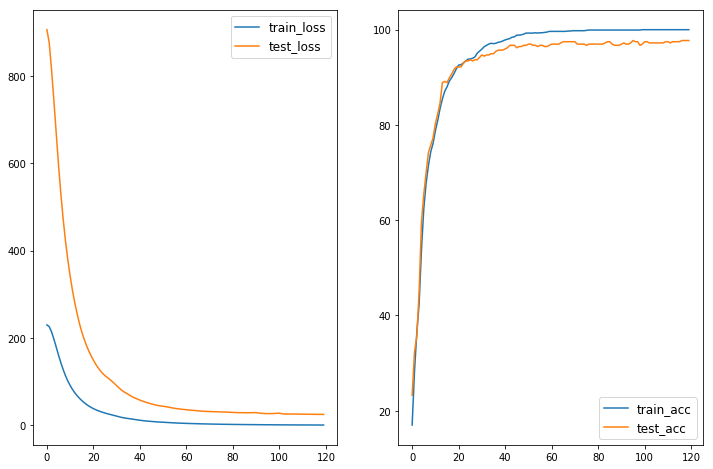

In [22]:
fig, axes = plt.subplots(1,2)

axes[0].plot(np.arange(120), train_loss, label='train_loss')
axes[0].plot(np.arange(120), test_loss, label='test_loss')
axes[0].legend(loc='upper right',prop={'size':12})

axes[1].plot(np.arange(120), train_acc, label='train_acc')
axes[1].plot(np.arange(120), test_acc, label='test_acc')
axes[1].legend(loc='lower right',prop={'size':12})

plt.show()

In [23]:
print('Min train loss:%.2f' % np.min(train_loss))
print('Max train accuracy:%.2f' % np.max(train_acc))
print('------------------------')
print('Min test loss:%.2f' % np.min(test_loss))
print('Max test accuracy:%.2f' % np.max(test_acc))

Min train loss:0.76
Max train accuracy:100.00
------------------------
Min test loss:25.02
Max test accuracy:97.73
